# BTCUSD Dataset 1

In [16]:
import pandas as pd 
import numpy as np
import talib as ta

import os
import pickle

import sklearn
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder

import xgboost as xgb

import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, Bidirectional, TimeDistributed, Conv1D, MaxPooling1D, Flatten, ConvLSTM2D
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
import sklearn.mixture as mix

import shap
import lime

from PIL import Image

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

from math import sqrt
sqn = lambda x: round(sqrt(sum(~np.isnan(x))) * np.nanmean(x) / np.nanstd(x), 4)
open_close_change = lambda Open, Close: (Close - Open) / Open 

In [2]:
# Function for resampling OHLC data

def resample_ohlc(df, interval = '4H'):

    df_open = df.resample(interval, base = 4)['Open'].first()
    df_high = df.resample(interval, base = 4)['High'].max()
    df_low = df.resample(interval, base = 4)['Low'].min()
    df_close = df.resample(interval, base = 4)['Close'].last()
    df_volume = df.resample(interval, base = 4)['Volume'].sum()
    df = pd.concat([df_open, df_high, df_low, df_close, df_volume], axis = 1)
    
    return df.dropna()



def process_data(df, indicators = ['AOP', 'open_close_change'], n_components = 5):

    filter_indicators = [x for x in indicators] + ['open_close_change']
        
    idx = df[filter_indicators].dropna().index
    X = df[filter_indicators].dropna().values
    
    model = mix.GaussianMixture(n_components = n_components, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)
    
    hidden_states = model.predict(X)
    
    # Compose into dataframes and join together; return 
    df_hidden_states = pd.DataFrame(hidden_states, index = idx, columns = ['hidden_state'])
    return df.join(df_hidden_states, how = 'inner')

### Creating different datasets to test

I'd like to try the machine learning workflow using a few different test datasets... where each dataset uses a different number of indicators and GMM "components" to create the data

In [3]:
if not os.path.exists("BTCUSD_Dataset1.csv"):
    # Read local data file 
    df_data = pd.read_csv('BTCUSD.csv', error_bad_lines = False)

    # Convert time to datetime format and set as index
    df_data['Time'] = pd.to_datetime(df_data['Time'])
    df_data.set_index('Time', inplace = True)

    # Resample the data for 4-hr OHLC bars

    df_data = resample_ohlc(df_data)

    # Calculate the PnL for the candle from open to close

    df_data['open_close_change'] = df_data.apply(lambda x: open_close_change(x['Open'], x['Close']), axis = 1)

    df_data1 = df_data.copy()

    # Add the indicators to df_data1
    df_data1['APO'] = ta.APO(df_data['Close']).shift()
    k, d = ta.STOCH(df_data['High'], df_data['Low'], df_data['Close'])
    df_data1['STOCH'] = (k-d).shift()
    k, d = ta.STOCHRSI(df_data['Close'])
    df_data1['STOCHRSI'] = (k-d).shift()

    # Define the number of regimes the GMM model will be identifying
    n_components_data1 = 5

    # Define indicator names for the GMM function
    indicators_data1 = ['APO', 'STOCH', 'STOCHRSI']

    # Dataset1
    dataset1 = process_data(df_data1, indicators_data1, n_components_data1)
    filter_columns = [x for x in indicators_data1] + ['hidden_state']
    dataset1 = dataset1[filter_columns]

    dataset1.to_csv("BTCUSD_Dataset1.csv")

else:
    dataset1 =  pd.read_csv("BTCUSD_Dataset1.csv")
    
dataset1

Time          APO      STOCH      STOCHRSI  hidden_state
0     2018-06-16 00:00:00   -35.396859  -8.995241  1.472102e+00             0
1     2018-06-16 04:00:00   -20.463782  -3.376553  3.828853e+01             0
2     2018-06-16 08:00:00   -12.573910   5.551317  1.195180e+01             0
3     2018-06-16 12:00:00     7.480192   2.470999 -3.732280e+01             1
4     2018-06-16 16:00:00     8.116026   8.506727  3.932404e+01             0
...                   ...          ...        ...           ...           ...
5762  2021-02-08 16:00:00   851.263782   2.735045 -3.410605e-13             4
5763  2021-02-08 20:00:00  1075.124167  -1.941947 -3.410605e-13             2
5764  2021-02-09 00:00:00  1424.452885   2.482697 -3.410605e-13             2
5765  2021-02-09 04:00:00  1676.505192   0.792058 -3.410605e-13             2
5766  2021-02-09 08:00:00  1902.481987 -10.022849 -6.666667e+01             2

[5767 rows x 5 columns]

### Machine Learning applications...

I am curious to see the various accuracies of the commonly used machine learning algorithms in predicting what the hidden states are for each of the three datasets. For example, is LSTM perhaps better than Densenet (or XGBoost, k-means, etc)?

In [4]:
from collections import Counter
print("Dataset Size : {}".format(dataset1.shape))
print("Unique Classes : {}".format(dataset1.hidden_state.unique()))
print("\nClass Distribution : ")
for cls in dataset1.hidden_state.unique():
    print("{} : {:.2f}".format(cls, dataset1.hidden_state.tolist().count(cls) / dataset1.shape[0]))
dataset1.head()

Dataset Size : (5767, 5)
Unique Classes : [0 1 3 4 2]

Class Distribution : 
0 : 0.65
1 : 0.15
3 : 0.14
4 : 0.02
2 : 0.03


Time        APO     STOCH   STOCHRSI  hidden_state
0  2018-06-16 00:00:00 -35.396859 -8.995241   1.472102             0
1  2018-06-16 04:00:00 -20.463782 -3.376553  38.288529             0
2  2018-06-16 08:00:00 -12.573910  5.551317  11.951801             0
3  2018-06-16 12:00:00   7.480192  2.470999 -37.322804             1
4  2018-06-16 16:00:00   8.116026  8.506727  39.324039             0

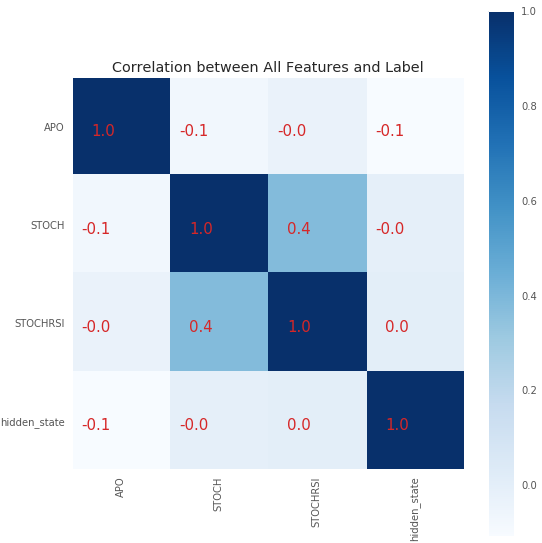

In [5]:
def plot_correlation_matrix(df, titl):
    plt.imshow(df.values, cmap=plt.cm.Blues)
    plt.xticks(range(df.shape[0]), df.columns, rotation='vertical')
    plt.yticks(range(df.shape[0]), df.columns)
    plt.title(titl)
    plt.colorbar()
    plt.grid(None)
    for i in range(0,df.shape[0]):
        for j in range(0, df.shape[0]):
            if df.values[i, j] < 0:
                plt.text(i-0.4, j+0.1, '%.1f'%df.values[i, j], color='tab:red', fontsize=15);
            else:
                plt.text(i-0.3, j+0.1, '%.1f'%df.values[i, j], color='tab:red', fontsize=15);
                
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(8,8))
    plot_correlation_matrix(dataset1.corr(), 'Correlation between All Features and Label')
                
    plt.tight_layout()
    
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
    
    #plt.savefig(os.path.join(batch,"correlation.png"), dpi=200)


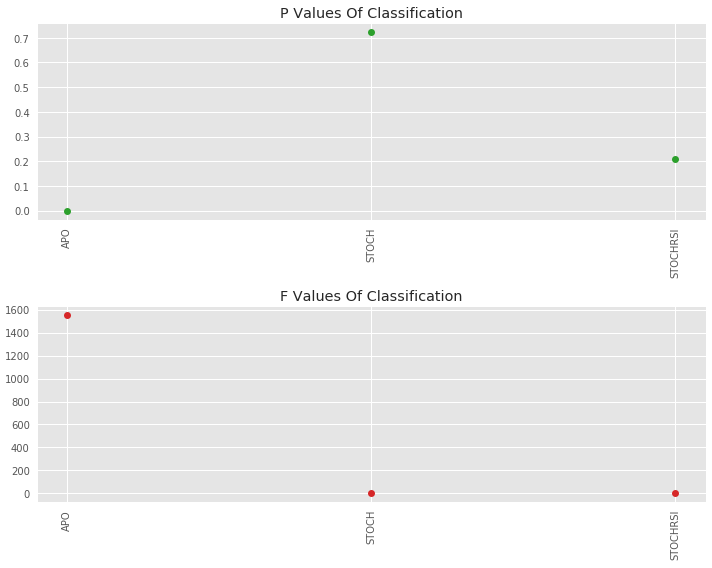

In [6]:
X = dataset1.drop(columns=["hidden_state", "Time"])
X = MinMaxScaler().fit_transform(X)
Y = dataset1['hidden_state'].values
#Y = np.array([1 if y==1 else 0 for y in Y])

cols = dataset1.drop(columns=["Time", "hidden_state"]).columns

F_classif, p_value_classif = f_classif(X, Y)

with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(10,8))
    plt.subplot(211)
    plt.plot(p_value_classif, 'o', c = 'tab:green')
    plt.xticks(range(X.shape[1]), cols, rotation='vertical')
    plt.title('P Values Of Classification')
    plt.subplot(212)
    plt.plot(F_classif, 'o', c = 'tab:red')
    plt.xticks(range(X.shape[1]), cols, rotation='vertical')
    plt.title('F Values Of Classification');
    
    plt.tight_layout()
    
    #plt.savefig(os.path.join(batch,"f_p_values.png"), dpi=200)

### Hidden State Trend

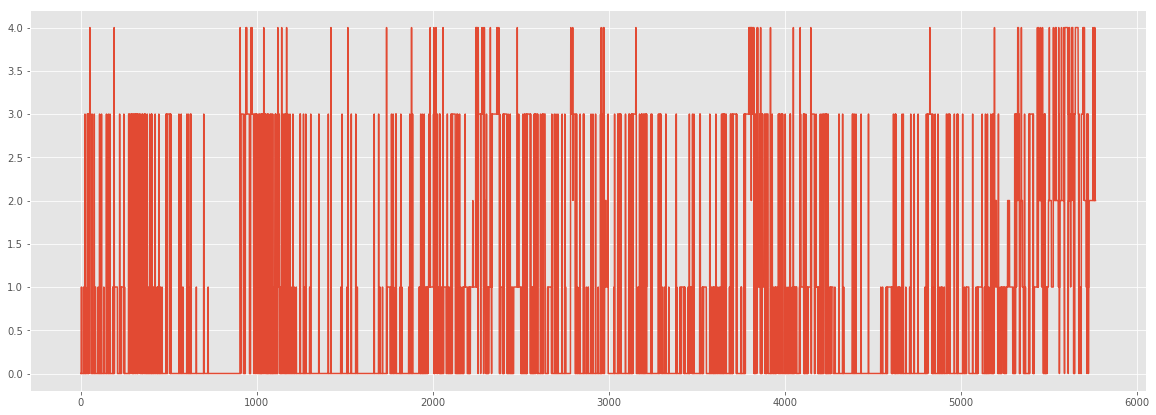

In [26]:
with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(20,7))
    plt.plot(dataset1.hidden_state)

## ML/DL Algorithms

In [31]:
def plot_loss_and_accuracy(hist, prob_type='classification'):
    with plt.style.context(('seaborn', 'ggplot')):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(hist.history['loss'], label='Train Loss')
        if "val_loss" in hist.history:
            plt.plot(hist.history['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='best')
        
        if prob_type=='classification':
            plt.subplot(122)
            plt.plot(hist.history['accuracy'], label='Train Accuracy')
            if "val_accuracy" in hist.history:
                plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(loc='best')
        elif prob_type=='regression':
            plt.subplot(122)
            plt.plot(hist.history['mse'], label='Train MSE')
            plt.plot(hist.history['val_mse'], label='Val MSE')
            plt.xlabel('Epochs')
            plt.ylabel('MSE')
            plt.legend(loc='best')
            
def print_plot_metrics(model_name, Y_test, predictions):
    print('Classification Report : \n',classification_report(Y_test, predictions))
    conf_mat = confusion_matrix(Y_test, predictions)
    print('Confusion Matrix : \n', conf_mat)
    #plot_confusion_matrix(conf_mat)
    
def plot_confusion_matrix(conf_mat):
    with plt.style.context(('seaborn', 'ggplot')):
        fig = plt.figure(figsize=(10,10))
        plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
        plt.xticks([0, 1], [-1, 1])
        plt.yticks([0, 1], [-1, 1])
        plt.grid(None)
        plt.ylabel('Actual')
        plt.xlabel('Prediction')
        plt.colorbar();
        for i in range(conf_mat.shape[0]):
            for j in range(conf_mat.shape[1]):
                plt.text(j, i, str(conf_mat[i, j]), horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
                

In [196]:
batch = "BTCUSD_Dataset1"

if not os.path.exists(batch):
    os.mkdir(batch)

X = dataset1.drop(columns = ["hidden_state", "Time"]).values
Y = dataset1["hidden_state"].values

print("Are there any NA in dataset? : {}".format(not np.alltrue(np.any(X))))

X.shape, Y.shape

Are there any NA in dataset? : False


((5767, 3), (5767,))

In [197]:
lookback = 5 ## Number of examples to lookback to make decision about future.

X_new, Y_new = [],[]

for i in range(X.shape[0] - lookback):
    X_new.append(X[i: i+lookback])
    Y_new.append(Y[i+lookback])
    
X_new, Y_new = np.array(X_new), np.array(Y_new)

print("Dataet Size : ",X_new.shape, Y_new.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y_new, 
                                                    train_size=0.97, 
                                                    shuffle=False)

print("\nTrain/Test Sizes : ",X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

print("\nClass Distribution (Y_train) : ")
for cls in np.unique(Y_train):
    print("{} : {}".format(cls, Y_train.tolist().count(cls)))

print("\nClass Distribution (Y_test) : ")
for cls in np.unique(Y_test):
    print("{} : {}".format(cls, Y_test.tolist().count(cls)))

Y_train_cat, Y_test_cat = keras.utils.to_categorical(Y_train), keras.utils.to_categorical(Y_test)

Y_train_cat.shape, Y_test_cat.shape

Dataet Size :  (5762, 5, 3) (5762,)

Train/Test Sizes :  (5589, 5, 3) (173, 5, 3) (5589,) (173,)

Class Distribution (Y_train) : 
0 : 3755
1 : 865
2 : 118
3 : 763
4 : 88

Class Distribution (Y_test) : 
0 : 13
1 : 17
2 : 55
3 : 41
4 : 47


((5589, 5), (173, 5))

### LSTM v1

In [180]:
lstm_classif_v1 = Sequential([
                        LSTM(150, input_shape=(X_train.shape[1], X_train.shape[2])),
                        Dropout(0.1),
                        Dense(Y_train_cat.shape[1], activation='softmax')                        
                        ])

print(lstm_classif_v1.summary())

#plot_model(lstm_classif_v1, to_file=os.path.join(batch, 'lstm_classif1.png'), show_shapes=True)
#Image.open(os.path.join(batch, 'lstm_classif1.png'))

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 150)               92400     
_________________________________________________________________
dropout_20 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 755       
Total params: 93,155
Trainable params: 93,155
Non-trainable params: 0
_________________________________________________________________
None


In [181]:
lstm_classif_v1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = lstm_classif_v1.fit(X_train, Y_train_cat, epochs=100, batch_size=16, verbose=2, shuffle=False)

Epoch 1/100
350/350 - 1s - loss: 0.7419 - accuracy: 0.7627
Epoch 2/100
350/350 - 1s - loss: 0.6449 - accuracy: 0.8010
Epoch 3/100
350/350 - 1s - loss: 0.6148 - accuracy: 0.8039
Epoch 4/100
350/350 - 1s - loss: 0.5872 - accuracy: 0.8100
Epoch 5/100
350/350 - 1s - loss: 0.5736 - accuracy: 0.8121
Epoch 6/100
350/350 - 1s - loss: 0.5597 - accuracy: 0.8234
Epoch 7/100
350/350 - 1s - loss: 0.5387 - accuracy: 0.8289
Epoch 8/100
350/350 - 1s - loss: 0.5321 - accuracy: 0.8230
Epoch 9/100
350/350 - 1s - loss: 0.5214 - accuracy: 0.8311
Epoch 10/100
350/350 - 1s - loss: 0.5055 - accuracy: 0.8390
Epoch 11/100
350/350 - 1s - loss: 0.4978 - accuracy: 0.8359
Epoch 12/100
350/350 - 1s - loss: 0.4861 - accuracy: 0.8383
Epoch 13/100
350/350 - 1s - loss: 0.4797 - accuracy: 0.8429
Epoch 14/100
350/350 - 1s - loss: 0.4666 - accuracy: 0.8454
Epoch 15/100
350/350 - 1s - loss: 0.4588 - accuracy: 0.8476
Epoch 16/100
350/350 - 1s - loss: 0.4524 - accuracy: 0.8486
Epoch 17/100
350/350 - 1s - loss: 0.4408 - accura

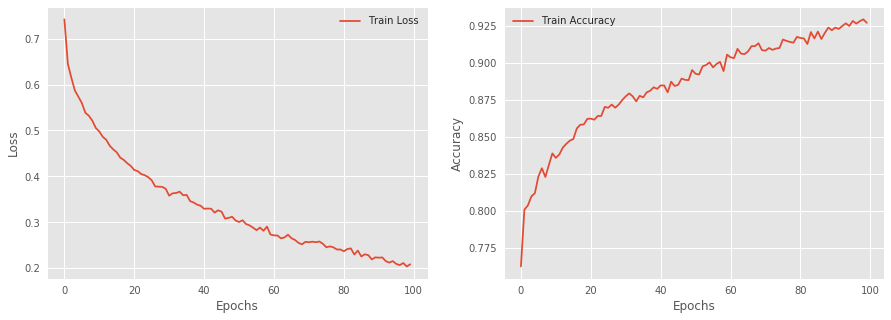

In [182]:
plot_loss_and_accuracy(history)

In [183]:
predictions = lstm_classif_v1.predict_classes(X_test)

print('Test Accuracy : %.3f\n'%accuracy_score(Y_test, predictions))

print_plot_metrics('LSTMV1', Y_test, predictions)

Test Accuracy : 0.728

Classification Report : 
               precision    recall  f1-score   support

           0       0.36      0.62      0.46        13
           1       0.46      0.65      0.54        17
           2       0.88      0.91      0.89        55
           3       0.72      0.63      0.68        41
           4       0.91      0.66      0.77        47

    accuracy                           0.73       173
   macro avg       0.67      0.69      0.67       173
weighted avg       0.77      0.73      0.74       173

Confusion Matrix : 
 [[ 8  4  0  1  0]
 [ 4 11  2  0  0]
 [ 0  4 50  0  1]
 [10  3  0 26  2]
 [ 0  2  5  9 31]]


### LSTM v2

In [198]:
lstm_classif_v2 = Sequential([
                LSTM(units=100, return_sequences= True, input_shape=(X_train.shape[1],X_train.shape[2])),
                LSTM(units=50, return_sequences=True),
                LSTM(units=30),
                Dense(Y_train_cat.shape[1], activation='softmax')
                ])

print(lstm_classif_v2.summary())

#plot_model(lstm_classif_v2, to_file=os.path.join(batch, 'lstm_classif2.png'), show_shapes=True)
#Image.open(os.path.join(batch, 'lstm_classif2.png'))

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 5, 100)            41600     
_________________________________________________________________
lstm_26 (LSTM)               (None, 5, 50)             30200     
_________________________________________________________________
lstm_27 (LSTM)               (None, 30)                9720      
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 155       
Total params: 81,675
Trainable params: 81,675
Non-trainable params: 0
_________________________________________________________________
None


In [199]:
lstm_classif_v2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = lstm_classif_v2.fit(X_train, Y_train_cat, epochs=100, batch_size=16, verbose=2, shuffle=False)

Epoch 1/100
350/350 - 3s - loss: 0.8330 - accuracy: 0.7143
Epoch 2/100
350/350 - 2s - loss: 0.6673 - accuracy: 0.7803
Epoch 3/100
350/350 - 3s - loss: 0.6237 - accuracy: 0.8016
Epoch 4/100
350/350 - 2s - loss: 0.6079 - accuracy: 0.8069
Epoch 5/100
350/350 - 2s - loss: 0.5902 - accuracy: 0.8145
Epoch 6/100
350/350 - 3s - loss: 0.5813 - accuracy: 0.8188
Epoch 7/100
350/350 - 3s - loss: 0.5774 - accuracy: 0.8170
Epoch 8/100
350/350 - 3s - loss: 0.5616 - accuracy: 0.8234
Epoch 9/100
350/350 - 3s - loss: 0.5487 - accuracy: 0.8302
Epoch 10/100
350/350 - 3s - loss: 0.5393 - accuracy: 0.8338
Epoch 11/100
350/350 - 3s - loss: 0.5288 - accuracy: 0.8368
Epoch 12/100
350/350 - 3s - loss: 0.5182 - accuracy: 0.8393
Epoch 13/100
350/350 - 3s - loss: 0.5073 - accuracy: 0.8420
Epoch 14/100
350/350 - 3s - loss: 0.4954 - accuracy: 0.8474
Epoch 15/100
350/350 - 3s - loss: 0.4884 - accuracy: 0.8477
Epoch 16/100
350/350 - 2s - loss: 0.4762 - accuracy: 0.8547
Epoch 17/100
350/350 - 2s - loss: 0.4700 - accura

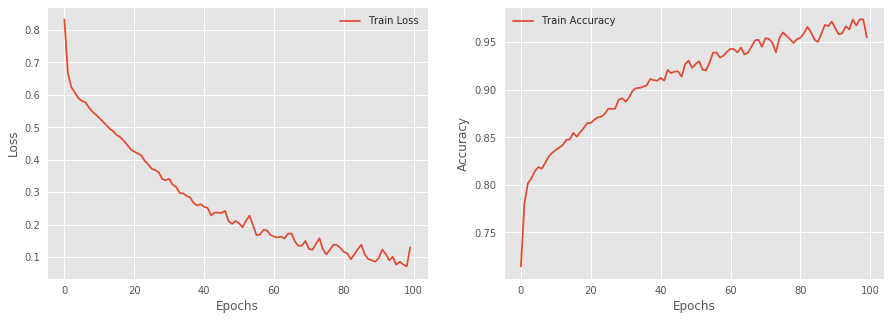

In [200]:
plot_loss_and_accuracy(history)

In [201]:
predictions = lstm_classif_v2.predict_classes(X_test)

print('Test Accuracy : %.3f\n'%accuracy_score(Y_test, predictions))

print_plot_metrics('LSTMV2', Y_test, predictions)

Test Accuracy : 0.734

Classification Report : 
               precision    recall  f1-score   support

           0       0.50      0.85      0.63        13
           1       0.60      0.71      0.65        17
           2       0.89      0.85      0.87        55
           3       0.65      0.63      0.64        41
           4       0.82      0.66      0.73        47

    accuracy                           0.73       173
   macro avg       0.69      0.74      0.70       173
weighted avg       0.75      0.73      0.74       173

Confusion Matrix : 
 [[11  0  0  2  0]
 [ 1 12  0  2  2]
 [ 0  6 47  1  1]
 [ 9  2  0 26  4]
 [ 1  0  6  9 31]]


### CNN LSTM

In [202]:
lstm_classif_v3 = Sequential([
    TimeDistributed(Conv1D(filters=32, kernel_size=1, activation='relu'), input_shape=(None, X_train.shape[1], X_train.shape[2])),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),
    LSTM(100, activation='relu'),
    Dense(Y_train_cat.shape[1], activation='softmax')
])


print(lstm_classif_v3.summary())

#plot_model(lstm_classif_v3, to_file=os.path.join(batch, 'lstm_classif3.png'), show_shapes=True)
#Image.open(os.path.join(batch, 'lstm_classif3.png'))

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, None, 5, 32)       128       
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 2, 32)       0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 64)          0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 100)               66000     
_________________________________________________________________
dense_31 (Dense)             (None, 5)                 505       
Total params: 66,633
Trainable params: 66,633
Non-trainable params: 0
_________________________________________________________________
None


In [203]:
lstm_classif_v3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = lstm_classif_v3.fit(X_train.reshape(X_train.shape[0],1,X_train.shape[1], X_train.shape[2]), Y_train_cat, epochs=100, batch_size=16, verbose=2, shuffle=False)

Epoch 1/100
350/350 - 0s - loss: 2.1659 - accuracy: 0.6744
Epoch 2/100
350/350 - 0s - loss: 1.3140 - accuracy: 0.6847
Epoch 3/100
350/350 - 1s - loss: 1.0408 - accuracy: 0.7032
Epoch 4/100
350/350 - 0s - loss: 1.0422 - accuracy: 0.7012
Epoch 5/100
350/350 - 0s - loss: 0.8365 - accuracy: 0.7357
Epoch 6/100
350/350 - 1s - loss: 0.8152 - accuracy: 0.7533
Epoch 7/100
350/350 - 0s - loss: 0.7751 - accuracy: 0.7454
Epoch 8/100
350/350 - 0s - loss: 0.7690 - accuracy: 0.7160
Epoch 9/100
350/350 - 0s - loss: 0.7609 - accuracy: 0.7157
Epoch 10/100
350/350 - 1s - loss: 0.7037 - accuracy: 0.7762
Epoch 11/100
350/350 - 1s - loss: 0.7196 - accuracy: 0.7354
Epoch 12/100
350/350 - 0s - loss: 0.7087 - accuracy: 0.7356
Epoch 13/100
350/350 - 0s - loss: 0.6945 - accuracy: 0.7787
Epoch 14/100
350/350 - 0s - loss: 0.7095 - accuracy: 0.7796
Epoch 15/100
350/350 - 0s - loss: 0.6821 - accuracy: 0.7821
Epoch 16/100
350/350 - 1s - loss: 0.6849 - accuracy: 0.7780
Epoch 17/100
350/350 - 0s - loss: 0.7071 - accura

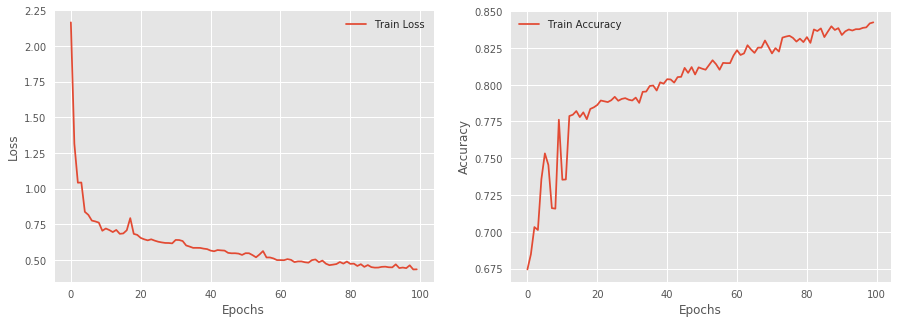

In [204]:
plot_loss_and_accuracy(history)

In [205]:
predictions = lstm_classif_v3.predict_classes(X_test.reshape(X_test.shape[0],1,X_test.shape[1], X_test.shape[2]))

print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

print_plot_metrics('CNN_LSTM', Y_test, predictions)

Accuracy : 0.318
Classification Report : 
               precision    recall  f1-score   support

           0       0.39      0.54      0.45        13
           1       0.15      0.65      0.24        17
           2       0.00      0.00      0.00        55
           3       0.43      0.56      0.49        41
           4       0.70      0.30      0.42        47

    accuracy                           0.32       173
   macro avg       0.33      0.41      0.32       173
weighted avg       0.34      0.32      0.29       173

Confusion Matrix : 
 [[ 7  3  0  3  0]
 [ 3 11  0  1  2]
 [ 1 51  0  1  2]
 [ 7  5  4 23  2]
 [ 0  5  3 25 14]]


### ConvLSTM

In [206]:
lstm_classif_v4 = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(1, 1, X_train.shape[1], X_train.shape[2])),
    Flatten(),
    Dense(Y_train_cat.shape[1], activation='softmax')
])


print(lstm_classif_v4.summary())

#plot_model(lstm_classif_v4, to_file=os.path.join(batch, 'lstm_classif4.png'), show_shapes=True)
#Image.open(os.path.join(batch, 'lstm_classif4.png'))

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 4, 64)          34560     
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 5)                 1285      
Total params: 35,845
Trainable params: 35,845
Non-trainable params: 0
_________________________________________________________________
None


In [207]:
lstm_classif_v4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = lstm_classif_v4.fit(X_train.reshape(X_train.shape[0],1, 1, X_train.shape[1], X_train.shape[2]), Y_train_cat, epochs=100, batch_size=16, verbose=2, shuffle=False)

Epoch 1/100
350/350 - 1s - loss: 1.1666 - accuracy: 0.7268
Epoch 2/100
350/350 - 1s - loss: 0.7839 - accuracy: 0.7797
Epoch 3/100
350/350 - 1s - loss: 0.7337 - accuracy: 0.7672
Epoch 4/100
350/350 - 0s - loss: 0.7630 - accuracy: 0.7924
Epoch 5/100
350/350 - 0s - loss: 0.6812 - accuracy: 0.7960
Epoch 6/100
350/350 - 0s - loss: 0.6430 - accuracy: 0.8009
Epoch 7/100
350/350 - 0s - loss: 0.6259 - accuracy: 0.7985
Epoch 8/100
350/350 - 0s - loss: 0.5980 - accuracy: 0.8084
Epoch 9/100
350/350 - 0s - loss: 0.5996 - accuracy: 0.8073
Epoch 10/100
350/350 - 1s - loss: 0.5910 - accuracy: 0.8091
Epoch 11/100
350/350 - 0s - loss: 0.5710 - accuracy: 0.8136
Epoch 12/100
350/350 - 0s - loss: 0.5673 - accuracy: 0.8170
Epoch 13/100
350/350 - 0s - loss: 0.5720 - accuracy: 0.8146
Epoch 14/100
350/350 - 0s - loss: 0.5632 - accuracy: 0.8146
Epoch 15/100
350/350 - 0s - loss: 0.5417 - accuracy: 0.8234
Epoch 16/100
350/350 - 0s - loss: 0.5481 - accuracy: 0.8195
Epoch 17/100
350/350 - 1s - loss: 0.5337 - accura

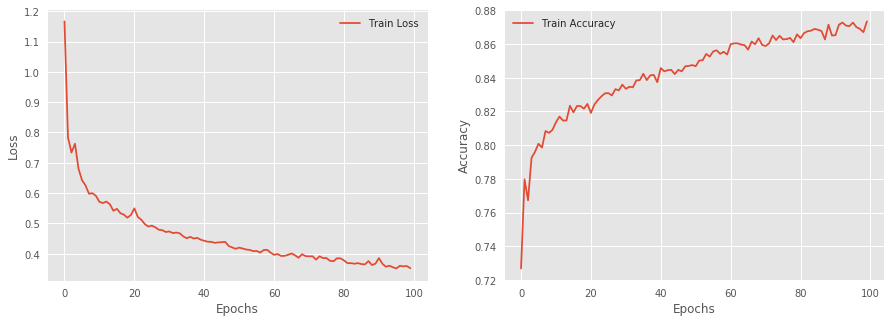

In [208]:
plot_loss_and_accuracy(history)

In [209]:
predictions = lstm_classif_v4.predict_classes(X_test.reshape(X_test.shape[0],1,1,X_test.shape[1], X_test.shape[2]))

print('Accuracy : %.3f\n'%accuracy_score(Y_test, predictions))
print_plot_metrics('CONV_LSTM', Y_test, predictions)

Accuracy : 0.538

Classification Report : 
               precision    recall  f1-score   support

           0       0.20      0.31      0.24        13
           1       0.33      0.53      0.41        17
           2       0.79      0.82      0.80        55
           3       0.43      0.46      0.45        41
           4       0.64      0.34      0.44        47

    accuracy                           0.54       173
   macro avg       0.48      0.49      0.47       173
weighted avg       0.57      0.54      0.54       173

Confusion Matrix : 
 [[ 4  3  0  6  0]
 [ 3  9  0  3  2]
 [ 1  6 45  1  2]
 [11  6  0 19  5]
 [ 1  3 12 15 16]]


### XGB Classifier

In [210]:
X_new, Y_new = X[:-1], Y[1:] ## Lookback is 1 in case of XGB and Dense nets. It can only support that.

X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y_new, 
                                                    train_size=0.97, 
                                                    shuffle=False,
                                                    )

print("Train/Test Sizes : ",X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

print("\nClass Distribution (Y_train) : ")
for cls in np.unique(Y_train):
    print("{} : {}".format(cls, Y_train.tolist().count(cls)))

print("\nClass Distribution (Y_test) : ")
for cls in np.unique(Y_test):
    print("{} : {}".format(cls, Y_test.tolist().count(cls)))

Y_train_cat, Y_test_cat = keras.utils.to_categorical(Y_train), keras.utils.to_categorical(Y_test)

Y_train_cat.shape, Y_test_cat.shape

Train/Test Sizes :  (5593, 3) (173, 3) (5593,) (173,)

Class Distribution (Y_train) : 
0 : 3758
1 : 866
2 : 118
3 : 763
4 : 88

Class Distribution (Y_test) : 
0 : 13
1 : 17
2 : 55
3 : 41
4 : 47


((5593, 5), (173, 5))

In [211]:
xgb_classif = xgb.XGBClassifier(n_estimators=250, max_depth=2, objective="multi:softmax", num_class=5)

xgb_classif.fit(X_train, Y_train, verbose=10)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=0, num_class=5, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [212]:
predictions = xgb_classif.predict(X_test)

print('Accuracy : %.3f\n'%accuracy_score(Y_test, predictions))
print_plot_metrics('XGBClassifier', Y_test, predictions)

Accuracy : 0.728

Classification Report : 
               precision    recall  f1-score   support

           0       0.32      0.77      0.45        13
           1       0.69      0.65      0.67        17
           2       0.88      0.89      0.88        55
           3       0.71      0.54      0.61        41
           4       0.87      0.72      0.79        47

    accuracy                           0.73       173
   macro avg       0.69      0.71      0.68       173
weighted avg       0.78      0.73      0.74       173

Confusion Matrix : 
 [[10  0  0  3  0]
 [ 5 11  1  0  0]
 [ 0  4 49  0  2]
 [15  1  0 22  3]
 [ 1  0  6  6 34]]


### LIME Interpretation

In [213]:
import random
random.seed(123)

j = random.randint(0, X_test.shape[0])

pred = xgb_classif.predict(X_test[j:j+1])[0]

print("Actual Value : {}".format(Y_test[j]))
print("Prediction   : {}\n".format(pred))


explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=dataset1.drop(columns=["Time", "hidden_state"]).columns,
                                                   #class_names=['Negative Return [-1]', "Positive Return [1]"],
                                                   training_labels=Y_train,
                                                   verbose=True,)

expXGB = explainer.explain_instance(X_test[j], 
                                    xgb_classif.predict_proba, 
                                    labels=[0,1,2,3,4],
                                    num_features=X_train.shape[0])

expXGB.show_in_notebook(show_table=True)

Actual Value : 4
Prediction   : 4

Intercept 0.6243009615774923
Prediction_local [0.33228618]
Right: 0.0016293094
Intercept 0.24848276131247266
Prediction_local [0.00141441]
Right: 0.0005894564
Intercept 0.06718342959232301
Prediction_local [0.00444837]
Right: 0.14774545
Intercept 0.04653224227224362
Prediction_local [0.63553928]
Right: 0.01756699
Intercept 0.013500606653774049
Prediction_local [0.02631175]
Right: 0.83246875


### XGB RF Classifier

In [214]:
xgb_rf_classif = xgb.XGBRFClassifier(n_estimators=250, max_depth=2, objective="multi:softmax", num_class=5)

xgb_rf_classif.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], verbose=10)

[0]	validation_0-merror:0.25433


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=0.8, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=1, max_delta_step=0, max_depth=2,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=250, n_jobs=0, num_class=5, num_parallel_tree=250,
                objective='multi:softprob', random_state=0, reg_alpha=0,
                reg_lambda=1e-05, scale_pos_weight=None, subsample=0.8,
                tree_method='exact', validate_parameters=1, verbosity=None)

In [215]:
predictions = xgb_rf_classif.predict(X_test)

print('Accuracy : %.3f\n'%accuracy_score(Y_test, predictions))
print_plot_metrics('XGBClassifier', Y_test, predictions)

Accuracy : 0.746

Classification Report : 
               precision    recall  f1-score   support

           0       0.33      0.77      0.47        13
           1       0.69      0.65      0.67        17
           2       0.88      0.93      0.90        55
           3       0.72      0.56      0.63        41
           4       0.92      0.72      0.81        47

    accuracy                           0.75       173
   macro avg       0.71      0.73      0.69       173
weighted avg       0.79      0.75      0.76       173

Confusion Matrix : 
 [[10  0  0  3  0]
 [ 5 11  1  0  0]
 [ 0  3 51  0  1]
 [15  1  0 23  2]
 [ 0  1  6  6 34]]


### LIME Interpretation

In [216]:
import random
random.seed(123)

j = random.randint(0, X_test.shape[0])

pred = xgb_rf_classif.predict(X_test[j:j+1])[0]

print("Actual Value : {}".format(Y_test[j]))
print("Prediction   : {}\n".format(pred))


explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=dataset1.drop(columns=["Time", "hidden_state"]).columns,
                                                   #class_names=['Negative Return [-1]', "Positive Return [1]"],
                                                   training_labels=Y_train,
                                                   verbose=True,)

expXGB = explainer.explain_instance(X_test[j], 
                                    xgb_rf_classif.predict_proba, 
                                    labels=[0,1,2,3,4],
                                    num_features=X_train.shape[0])

expXGB.show_in_notebook(show_table=True)

Actual Value : 4
Prediction   : 4

Intercept 0.5447217715360121
Prediction_local [0.41483669]
Right: 0.21125263
Intercept 0.20755892333566622
Prediction_local [0.06161632]
Right: 0.06717473
Intercept 0.10288953500191877
Prediction_local [0.05920704]
Right: 0.0693649
Intercept 0.07860587351695188
Prediction_local [0.40312957]
Right: 0.19670156
Intercept 0.06622389595090707
Prediction_local [0.06121039]
Right: 0.45550618


### Dense Nets

In [217]:
dense_model1 = Sequential([ 
                     Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
                     #BatchNormalization(),      
                     Dropout(0.2),
                     Dense(64,  activation='relu'),
                     #BatchNormalization(),  
                     Dropout(0.2),
                     Dense(32,  activation='relu'),
                     #BatchNormalization(),
                     Dropout(0.2),
                     Dense(5,   activation='softmax')])

print(dense_model1.summary())
#plot_model(dense_model1, to_file=os.path.join(batch, 'dense1.png'), show_shapes=True)
#Image.open(os.path.join(batch, 'dense1.png'))

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 128)               512       
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_26 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 5)               

In [218]:
dense_model1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = dense_model1.fit(X_train, Y_train_cat, batch_size=16, epochs=100, verbose=1,shuffle=False, use_multiprocessing=True);

Epoch 1/100
350/350 [==============================] - 0s 712us/step - loss: 2.2140 - accuracy: 0.5400
Epoch 2/100
350/350 [==============================] - 0s 616us/step - loss: 1.2122 - accuracy: 0.6717
Epoch 3/100
350/350 [==============================] - 0s 570us/step - loss: 1.0703 - accuracy: 0.6864
Epoch 4/100
350/350 [==============================] - 0s 791us/step - loss: 0.9617 - accuracy: 0.7096
Epoch 5/100
350/350 [==============================] - 0s 918us/step - loss: 0.9149 - accuracy: 0.7223
Epoch 6/100
350/350 [==============================] - 0s 609us/step - loss: 0.8624 - accuracy: 0.7336
Epoch 7/100
350/350 [==============================] - 0s 567us/step - loss: 0.8521 - accuracy: 0.7239
Epoch 8/100
350/350 [==============================] - 0s 642us/step - loss: 0.8017 - accuracy: 0.7490
Epoch 9/100
350/350 [==============================] - 0s 798us/step - loss: 0.7948 - accuracy: 0.7497
Epoch 10/100
350/350 [==============================] - 0s 795us/step - l

350/350 [==============================] - 0s 543us/step - loss: 0.5844 - accuracy: 0.8169
Epoch 80/100
350/350 [==============================] - 0s 542us/step - loss: 0.5738 - accuracy: 0.8169
Epoch 81/100
350/350 [==============================] - 0s 571us/step - loss: 0.5763 - accuracy: 0.8194
Epoch 82/100
350/350 [==============================] - 0s 538us/step - loss: 0.5737 - accuracy: 0.8183
Epoch 83/100
350/350 [==============================] - 0s 543us/step - loss: 0.5828 - accuracy: 0.8155
Epoch 84/100
350/350 [==============================] - 0s 554us/step - loss: 0.5707 - accuracy: 0.8175
Epoch 85/100
350/350 [==============================] - 0s 547us/step - loss: 0.5798 - accuracy: 0.8180
Epoch 86/100
350/350 [==============================] - 0s 569us/step - loss: 0.5760 - accuracy: 0.8187
Epoch 87/100
350/350 [==============================] - 0s 840us/step - loss: 0.5665 - accuracy: 0.8192
Epoch 88/100
350/350 [==============================] - 0s 908us/step - loss:

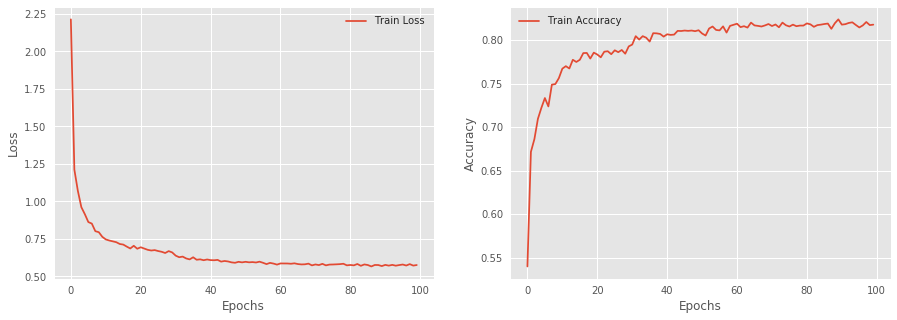

In [219]:
plot_loss_and_accuracy(history)

In [220]:
predictions = dense_model1.predict_classes(X_test)
print('Accuracy : %.3f\n'%accuracy_score(Y_test, predictions))

print_plot_metrics('DenseNetv1', Y_test, predictions)

Accuracy : 0.705

Classification Report : 
               precision    recall  f1-score   support

           0       0.31      0.69      0.43        13
           1       0.61      0.65      0.63        17
           2       0.88      0.91      0.89        55
           3       0.60      0.61      0.60        41
           4       1.00      0.57      0.73        47

    accuracy                           0.71       173
   macro avg       0.68      0.69      0.66       173
weighted avg       0.77      0.71      0.72       173

Confusion Matrix : 
 [[ 9  1  0  3  0]
 [ 5 11  1  0  0]
 [ 0  4 50  1  0]
 [15  1  0 25  0]
 [ 0  1  6 13 27]]


### LIME Interpretation

In [221]:
import random
random.seed(123)

j = random.randint(0, X_test.shape[0])

pred = dense_model1.predict_classes(X_test[j:j+1])[0]

print("Actual Value : {}".format(Y_test[j]))
print("Prediction   : {}\n".format(pred))


explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=dataset1.drop(columns=["Time", "hidden_state"]).columns,
                                                   #class_names=['Negative Return [-1]', "Positive Return [1]"],
                                                   training_labels=Y_train,
                                                   verbose=True,)

expXGB = explainer.explain_instance(X_test[j], 
                                    dense_model1.predict_proba, 
                                    labels=[0,1,2,3,4],
                                    num_features=X_train.shape[0])

expXGB.show_in_notebook(show_table=True)

Actual Value : 4
Prediction   : 4

Intercept 0.6001512181446209
Prediction_local [0.41195271]
Right: 4.1821197e-15
Intercept 0.24423092582543598
Prediction_local [0.01805231]
Right: 4.406346e-29
Intercept 0.07834132147591448
Prediction_local [0.0205577]
Right: 0.04046186
Intercept 0.05322948787241136
Prediction_local [0.51755246]
Right: 0.16426006
Intercept 0.02404703869581288
Prediction_local [0.03188482]
Right: 0.79527813
